# Homework 6 - Color Magnitude Diagrams
## by Brad Lyke 
### Part 1a and 1b

For this I used a combination of IRAF to do photometric extraction on the sources and python to plot the color magnitude diagrams.

### A) IRAF Photometry
I used the following commands to pull x-y centers for the different stars in a B,V, and R image. I chose the longer exposures as they should have had higher SNR.
- daofind a160_zbf.fits with parameters: FWHM=3,STD=9,THRESH=4,MIN=1000,MAX=50000 (B)
- daofind a159_zbf.fits with parameters: FWHM=3,STD=9,THRESH=4,MIN=1000,MAX=50000 (V)
- daofind a155_zbf.fits with parameters: FWHM=3,STD=9,THRESH=4,MIN=1000,MAX=50000 (R)

I edited the output files (taking away the header information) and used this as coordinate files that I fed into phot:
- phot a160_zbf.fits coords='a160_zbf.fits.coo.2' output='a160_ext.dat' datapars.itime=12 datapars.xairma=1.09 interact- verify-
- phot a159_zbf.fits coords='a159_zbf.fits.coo.2' output='a159_ext.dat' datapars.itime=12 datapars.xairma=1.09 interact- verify-
- phot a155_zbf.fits coords='a155_zbf.fits.coo.2' output='a155_ext.dat' datapars.itime=6 datapars.xairma=1.10 interact- verify-

After these, I used txdump to clean up the photometry files with X/Y center outputs to match the objects in each image. In the future I would probably stack the images using imshift first, then run one set of coordinate files.
- txdump a160_ext.dat LID,XCENTER,YCENTER,MSKY,FLUX,MAG,MERR,SUM expr="yes" > a160_ext_clean2.dat
- txdump a159_ext.dat LID,XCENTER,YCENTER,MSKY,FLUX,MAG,MERR,SUM expr="yes" > a159_ext_clean2.dat
- txdump a155_ext.dat LID,XCENTER,YCENTER,MSKY,FLUX,MAG,MERR,SUM expr="yes" > a155_ext_clean2.dat

After this was complete, I shifted over to the python you see below.

In [99]:
#Importing all of the modules I will need.
import numpy as np
from astropy.io import fits
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['figure.figsize']=(15.0,12.0)
matplotlib.rc('font',size=20)

In [100]:
#Load up the phot files. These are the photometric data files output from txdump.
braw = np.loadtxt('a160_ext_clean2.dat',dtype=bytes).astype('f4')
rraw = np.loadtxt('a155_ext_clean2.dat',dtype=bytes).astype('f4')
vraw = np.loadtxt('a159_ext_clean2.dat',dtype=bytes).astype('f4')

In [101]:
#This is a simple script I wrote to make an array of straight-distance separation between two
#sets of x-y coordinates. The output is an array of distances in pixels.
def xysep(x_ref,y_ref,x_comp,y_comp):
    num_comps = len(x_comp)
    dist_arr = np.zeros(num_comps,dtype='f4')
    for i in range(num_comps):
        r_temp = np.sqrt((x_ref-x_comp[i])**(2.0)+(y_ref - y_comp[i])**(2.0))
        dist_arr[i] = r_temp
    return dist_arr

In [34]:
#Put phot files into arrays
barray = np.zeros(len(braw),dtype=[('X','f4'),('Y','f4'),('MSKY','f4'),('FLUX','f4'),('MAG','f4'),
                                  ('MAG_ERR','f4'),('SUM','f4')])
rarray = np.zeros(len(rraw),dtype=[('X','f4'),('Y','f4'),('MSKY','f4'),('FLUX','f4'),('MAG','f4'),
                                  ('MAG_ERR','f4'),('SUM','f4')])
varray = np.zeros(len(vraw),dtype=[('X','f4'),('Y','f4'),('MSKY','f4'),('FLUX','f4'),('MAG','f4'),
                                  ('MAG_ERR','f4'),('SUM','f4')])
colnames = np.array(barray.dtype.names)

#This loads them up into structured arrays that are easier for me to manipulate, and so I can
#call on columns by name rather than remembering what column number they are.
for i in range(7):
    barray[colnames[i]] = braw[:,i+1]
    rarray[colnames[i]] = rraw[:,i+1]
    varray[colnames[i]] = vraw[:,i+1]
    
#I only want to keep the number of objects that appears in the file with the fewest number of stars.
num_obj = np.array([len(braw),len(rraw),len(vraw)])
min_obj = np.amin(num_obj)
phot_array = np.zeros(min_obj,dtype=[('X','f4'),('Y','f4'),('B_MAG_raw','f4'),('V_MAG_raw','f4'),
                                    ('R_MAG_raw','f4'),('B_MAG_corr','f4'),('V_MAG_corr','f4'),
                                    ('R_MAG_corr','f4'),('B-V','f4'),('V-R','f4')])
#Load the B-band information into the photometric array which will store all data for each object.
phot_array['X'] = barray['X']
phot_array['Y'] = barray['Y']
phot_array['B_MAG_raw'] = barray['MAG']
#Separation matching. The min_sepR,min_sepV threshholds found by experimentation.
for i in range(min_obj):
    #Find V and R objects matching B object
    x_0 = phot_array['X'][i]
    y_0 = phot_array['Y'][i]
    sep_arrayR = xysep(x_0,y_0,rarray['X'],rarray['Y'])
    sep_arrayV = xysep(x_0,y_0,varray['X'],varray['Y'])
    min_sepR = np.amin(sep_arrayR)
    min_sepV = np.amin(sep_arrayV)
    if min_sepR <= 7.5:
        wRmin = np.where(sep_arrayR == min_sepR)[0]
        phot_array['R_MAG_raw'][i] = rarray['MAG'][wRmin[0]]
    if min_sepV <= 7.0:
        wVmin = np.where(sep_arrayV == min_sepV)[0]
        phot_array['V_MAG_raw'][i] = varray['MAG'][wVmin[0]]
    

#Correction values from last homework
kb1 = -0.385
kv1 = -0.448
kr1 = -0.659
zb1 = -0.225
zv1 = 0.045
zr1 = 0.396
bvc = 0.111
vrc = -0.012
#Do the corrections based on standard stars.
phot_array['B_MAG_corr'] = phot_array['B_MAG_raw'] + (kb1 * 1.09) + zb1
phot_array['V_MAG_corr'] = phot_array['V_MAG_raw'] + (kv1 * 1.09) + zv1
phot_array['R_MAG_corr'] = phot_array['R_MAG_raw'] + (kr1 * 1.10) + zr1
phot_array['B-V'] = (phot_array['B_MAG_corr'] - phot_array['V_MAG_corr']) + bvc
phot_array['V-R'] = (phot_array['V_MAG_corr'] - phot_array['R_MAG_corr']) + vrc

In [102]:
#I got a set of data from Guetter 1992. See the final entry to a full bibliographic entry.
#This table includes magnitudes for V and B-V (and U-B, but I didn't need that).
ngc_dat = np.loadtxt('6823.dat',dtype=bytes).astype(str)
ngc_arr = np.zeros(len(ngc_dat),dtype=[('V','f4'),('B-V','f4')])
ngc_arr['V'] = ngc_dat[:,3]
ngc_arr['B-V'] = ngc_dat[:,4]

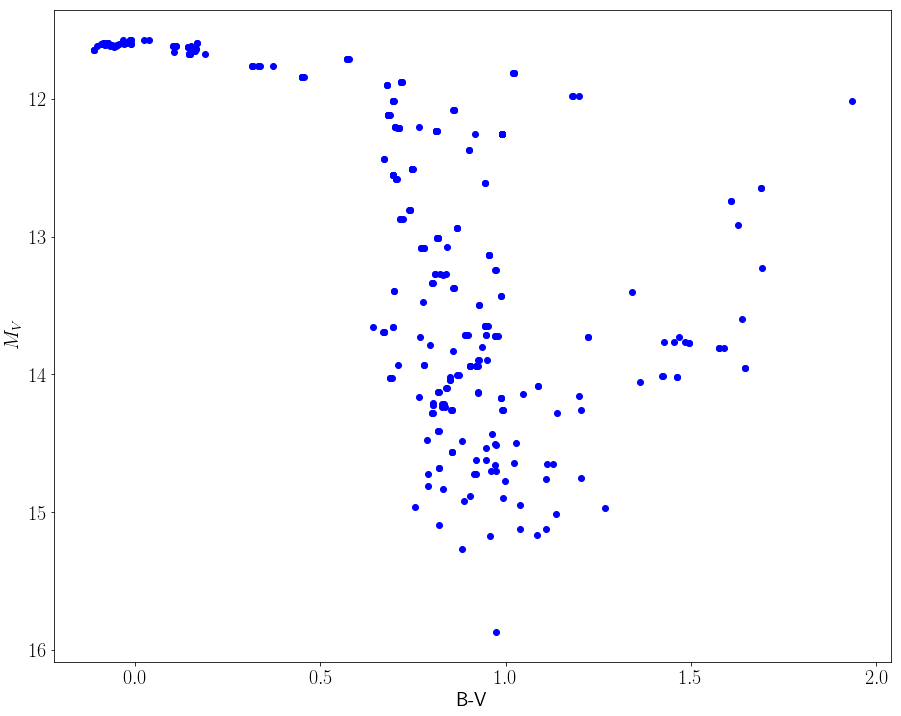

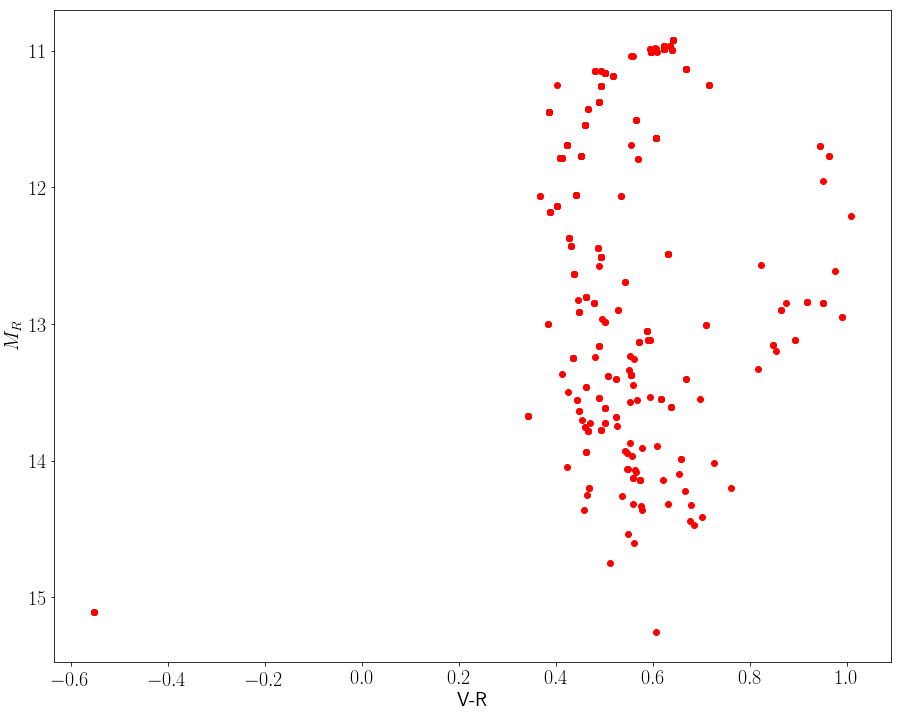

In [104]:
#Here we plot the Mv vs. B-V and Mr vs. V-R. I chose to do both just to see what they looked like.
#Note that the y-axis in each image is reversed, with brighter magnitudes at the top. (I hate
#the magnitude system. Seriously, we could reverse it. It would be, like, one bad week.)
fig1,ax1 = plt.subplots()
ax1.scatter(phot_array['B-V'],phot_array['V_MAG_corr'],color='blue')
ax1.set_xlabel('B-V')
ax1.set_ylabel(r'$M_{V}$');
plt.gca().invert_yaxis()

fig2,ax2 = plt.subplots()
ax2.scatter(phot_array['V-R'],phot_array['R_MAG_corr'],color='red')
ax2.set_xlabel('V-R')
ax2.set_ylabel(r'$M_{R}$');
plt.gca().invert_yaxis()

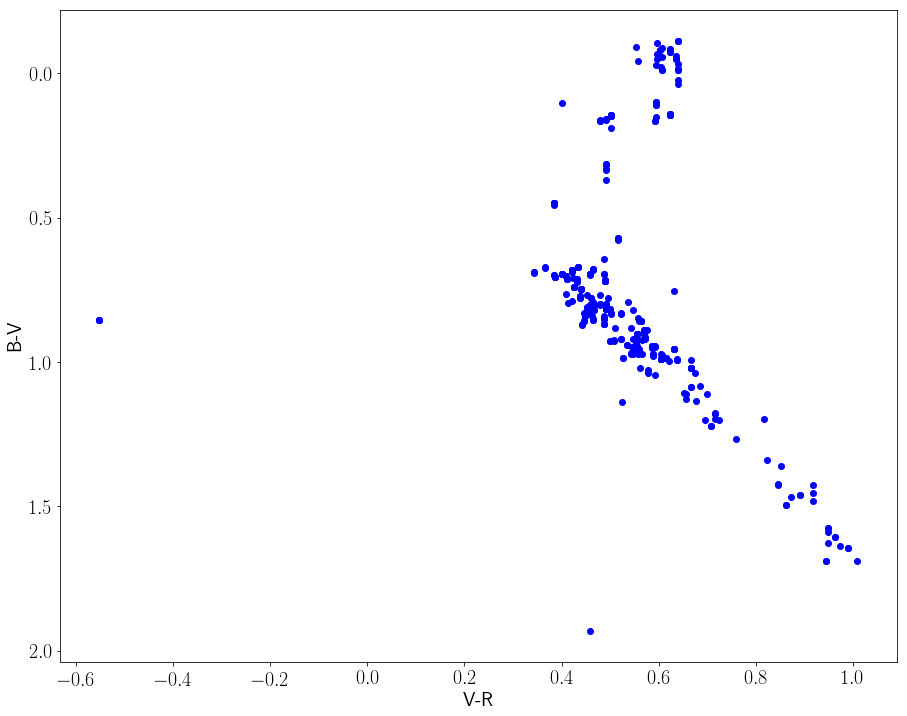

In [54]:
#This is a color-color diagram for fun. B-V vs. V-R. I've seen these before. I would love to
#know what those two weird outliers are. I would bet they aren't stars and I could discount them
#from later plots.
fig3,ax3 = plt.subplots()
ax3.scatter(phot_array['V-R'],phot_array['B-V'],color='blue')
ax3.set_xlabel('V-R')
ax3.set_ylabel('B-V')
plt.gca().invert_yaxis()

1.8 [9.96]
1.93367 [12.0136795]


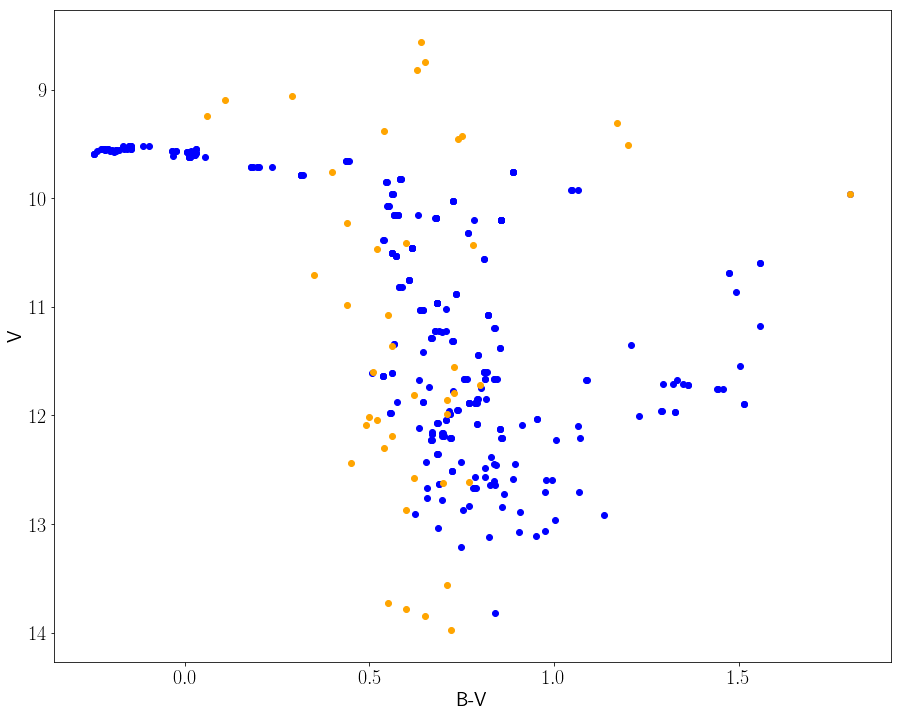

In [68]:
#This is my first attempt at dereddening.
#This didn't work. Fixing it is not a straight xy shift based on a single point.
ngc_bvm = np.amax(ngc_arr['B-V'])
wngc = np.where(ngc_arr['B-V']==ngc_bvm)[0]
ngc_vm = ngc_arr['V'][wngc]
print(ngc_bvm,ngc_vm)

phot_bvm = np.amax(phot_array['B-V'])
wphot = np.where(phot_array['B-V']==phot_bvm)[0]
phot_vm = phot_array['V_MAG_corr'][wphot]
print(phot_bvm,phot_vm)

v_corr = phot_vm[0] - ngc_vm[0]
bv_corr = phot_bvm - ngc_bvm
v_array = phot_array['V_MAG_corr'] - v_corr
bv_array = phot_array['B-V'] - bv_corr

fig4,ax4 = plt.subplots()
ax4.scatter(bv_array,v_array,color='blue')
ax4.scatter(ngc_arr['B-V'],ngc_arr['V'],color='orange')
ax4.set_xlabel('B-V')
ax4.set_ylabel('V')
plt.gca().invert_yaxis()

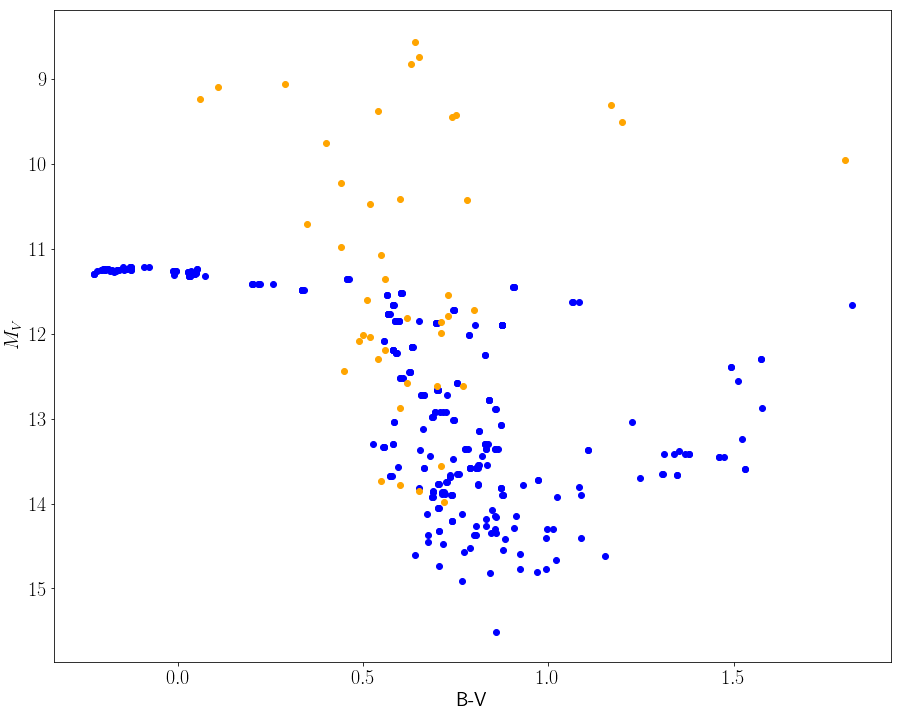

In [105]:
#Dereddening, this also didn't work very well. See explanation below.
Rv = 3.1
vcorr = (3.2)*0.111
bv_arr2 = phot_array['B-V'] - (vcorr/Rv)
v_arr2 = phot_array['V_MAG_corr'] - vcorr
fig5,ax5 = plt.subplots()
ax5.scatter(bv_arr2,v_arr2,color='blue')
ax5.scatter(ngc_arr['B-V'],ngc_arr['V'],color='orange')
ax5.set_xlabel('B-V')
ax5.set_ylabel(r'$M_{V}$')
plt.gca().invert_yaxis()

My color-magnitude diagram somewhat matches the data provided by Guetter (1992, AJ) but appears to be squashed in the vertical direction and somewhat stretched in the horizontal direction. In addition, I used DAOFIND in IRAF to get the centers of all stars as they appeared in B,V, and R images, but this means I pulled more stars than NGC 6823 has members. Looking only at the matching "members" by general shape, my CMD still seems morphed along both axes. This may be due to incorrect color matching in the previous homework steps, leading to the wrong color-correction coefficients being generated. I also may be doing the dereddening incorrectly as this method uses E(B-V), which is, again, using my color-correction terms from the previous homework.

Note that the orange points above come from Guetter, H. AJ 103, pp197-203 for NGC 6823 members.

### B) Platescale
Using the standard stars image, a085_zbf.fits, I'm using PG1633+099B and PG1633+099D as they are both in the Landolt 1992 paper and fairly close together.

Below, x and y are pixel coordinates.

- 099B: ra = 16:35:34, dec = +09 46 22, x=1252.7, y=1222.6
- 099D: ra = 16:35:40, dec = +09 46 43, x=1445.0, y=1183.1

separation is defined by:
$\Delta l = \sqrt{(\Delta \alpha)^{2} + (\Delta \delta)^{2}}$

For these two objects, $\Delta \delta = 21.0''$, and $\Delta \alpha = 6~\text{sec} * 15 '' * \cos(9) = 88.9''$.

Therefore $\Delta l = \sqrt{21^{2} + 88.9^{2}} = 91.3 ''$ on the sky.

The pixel separation of the two is defined by $r = \sqrt{(x_{B} - x_{D})^{2} + (y_{B}-y_{D})^{2}}$. For these two that is $r = \sqrt{30.1^{2} + 261.9^{2}} = 263.6~\text{pix}$.

Then the plate scale is $p = \Delta l / r = 91.3 / 263.6 = 0.346~''/\text{pix}$. With WIRO Prime's listed 13.5 $\mu$m pixels, this corresponds to $p = 0.346 / 13.5 = 0.0256~''/\mu \text{m}$.

$p = 0.346~''/\text{pix} = 0.0256~''/\mu \text{m}$.